In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

## Common setup

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from src.models.siamese_triplet.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, ncluster, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    inds = np.where(targets==ncluster)[0]
    plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[ncluster])  # np.random.rand(3,)
    for i in range(ncluster):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])  # np.random.rand(3,)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)


def get_labels(dataloader, label_anchors):
    if label_anchors.shape[0] == 1:
        x1 = dataloader.dataset.data[label_anchors].unsqueeze(dim=0)
    else:
        x1 = dataloader.dataset.data[label_anchors]
    dist = torch.cdist(x1=x1, x2=dataloader.dataset.data, p=2)  # (n, n)
    sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
    
    num_anchors = label_anchors.shape[0]
    n = dataloader.dataset.data.shape[0]
    labels = - torch.ones(n)
    for i in range(num_anchors):
        labels[indices[i, :100]] = i
    labels[labels==-1.] = num_anchors
    return labels
    


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        size = dataloader.dataset.data.shape[0]
        batch_size = 256
        embedded_x_list = list()
        for i in tqdm(range(size // batch_size + 1)):
            batch_x = dataloader.dataset.data[batch_size * i: batch_size * (i + 1)].float().to('cuda:0')
            embedded_x = model.get_embedding(batch_x).to('cpu')
            embedded_x_list.append(embedded_x)
    return torch.cat(embedded_x_list, dim=0)

$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

In [3]:
# Set up data loaders
from src.models.siamese_triplet.datasets import SiameseSynthesis
from pathlib import Path

siamese_train_dataset = SiameseSynthesis(Path('../data/train.pt')) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseSynthesis(Path('../data/dev.pt'))
batch_size = 2048
kwargs = {'num_workers': 32, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet, SiameseNet
from src.models.siamese_triplet.losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()

loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 5
log_interval = 100

In [4]:
best_model, lowest_val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/18000000 (0%)]	Loss: 0.362560
Train: [0/18000000 (0%)]	Loss: 0.362560
Validation set: Average loss: 0.2080
Train: [204800/18000000 (1%)]	Loss: 0.006783
Train: [204800/18000000 (1%)]	Loss: 0.006783
Validation set: Average loss: 0.0305
Train: [409600/18000000 (2%)]	Loss: 0.000178
Train: [409600/18000000 (2%)]	Loss: 0.000178
Validation set: Average loss: 0.0236
Train: [614400/18000000 (3%)]	Loss: 0.000130
Train: [614400/18000000 (3%)]	Loss: 0.000130
Validation set: Average loss: 0.0180
Train: [819200/18000000 (5%)]	Loss: 0.000098
Train: [819200/18000000 (5%)]	Loss: 0.000098
Validation set: Average loss: 0.0142
Train: [1024000/18000000 (6%)]	Loss: 0.000076
Train: [1024000/18000000 (6%)]	Loss: 0.000076
Validation set: Average loss: 0.0115
Train: [1228800/18000000 (7%)]	Loss: 0.000061
Train: [1228800/18000000 (7%)]	Loss: 0.000061
Validation set: Average loss: 0.0094
Train: [1433600/18000000 (8%)]	Loss: 0.000050
Train: [1433600/18000000 (8%)]	Loss: 0.000050
Validation set: Average l

Train: [12902400/18000000 (72%)]	Loss: 0.000002
Train: [12902400/18000000 (72%)]	Loss: 0.000002
Validation set: Average loss: 0.0079
Train: [13107200/18000000 (73%)]	Loss: 0.000002
Train: [13107200/18000000 (73%)]	Loss: 0.000002
Validation set: Average loss: 0.0080
Train: [13312000/18000000 (74%)]	Loss: 0.000002
Train: [13312000/18000000 (74%)]	Loss: 0.000002
Validation set: Average loss: 0.0079
Train: [13516800/18000000 (75%)]	Loss: 0.000002
Train: [13516800/18000000 (75%)]	Loss: 0.000002
Validation set: Average loss: 0.0080
Train: [13721600/18000000 (76%)]	Loss: 0.000002
Train: [13721600/18000000 (76%)]	Loss: 0.000002
Validation set: Average loss: 0.0080
Train: [13926400/18000000 (77%)]	Loss: 0.000002
Train: [13926400/18000000 (77%)]	Loss: 0.000002
Validation set: Average loss: 0.0080
Train: [14131200/18000000 (78%)]	Loss: 0.000002
Train: [14131200/18000000 (78%)]	Loss: 0.000002
Validation set: Average loss: 0.0079
Train: [14336000/18000000 (80%)]	Loss: 0.000001
Train: [14336000/1800

In [ ]:
embedded_x = extract_embeddings(siamese_train_loader, best_model)
labels = get_labels(siamese_train_loader, 10 * torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]))
plot_embeddings(siamese_train_loader.dataset.data, labels, ncluster=9)
plot_embeddings(embedded_x, labels, ncluster=9)

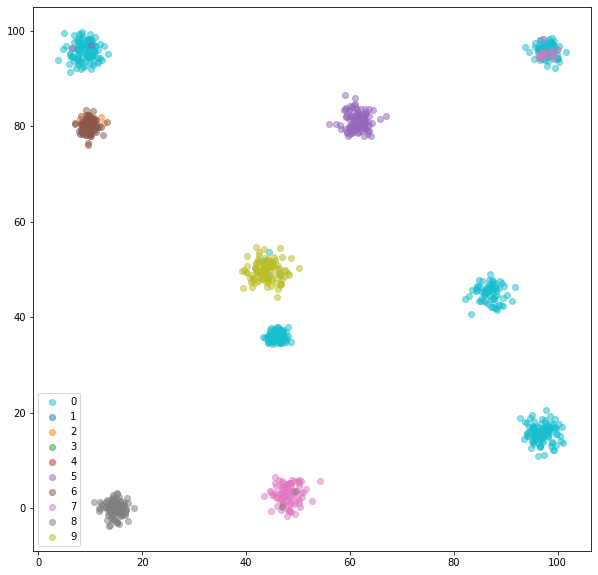

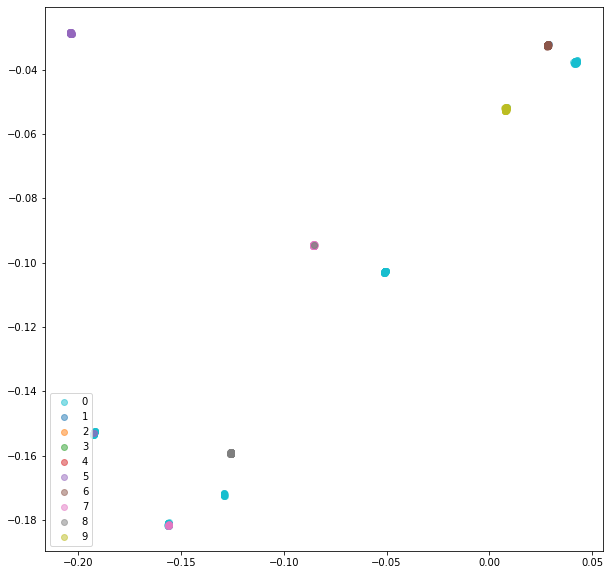

In [107]:
embedded_x = extract_embeddings(siamese_test_loader, best_model)
labels = get_labels(siamese_test_loader, torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]))
plot_embeddings(siamese_test_loader.dataset.data, labels, ncluster=9)
plot_embeddings(embedded_x, labels, ncluster=9)

In [113]:
def far_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, -100], indices[:, -100]


def close_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, :9000], indices[:, :9000]


def calculate_distance(x, close_fn, far_fn):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    batch_size = 2048
    x_device = x.to(device)
    
    num_iter = x.shape[0] // batch_size + 1
    anchor_idx_list, close_idx_list, far_idx_list = list(), list(), list()
    close_distance_list, far_distance_list = list(), list()
    for i in tqdm(torch.arange(num_iter), desc='create triplets'):
        batch_x = x[i * batch_size: (i + 1) * batch_size, :].to(device)

        dist = torch.cdist(x1=batch_x, x2=x_device, p=2)  # (n, n)
        sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
        sorted_dist, indices = sorted_dist, indices
        anchor_idx = torch.arange(i * batch_size, i * batch_size + batch_x.shape[0])  # (n,)
        # assert torch.equal(anchor_idx, indices[:, 0].cpu())
        # the 0-th column is the distance to oneself
        close_distance, close_idx = close_fn(sorted_dist, indices)  # (n,)
        far_distance, far_idx = far_fn(sorted_dist, indices)  # (n, r)
        anchor_idx_list.append(anchor_idx.cpu())
        close_idx_list.append(close_idx.cpu())
        far_idx_list.append(far_idx.cpu())
        close_distance_list.append(close_distance.cpu())
        far_distance_list.append(far_distance.cpu())
    anchor_idx_list = torch.cat(anchor_idx_list, dim=0)
    close_idx_list = torch.cat(close_idx_list, dim=0)
    far_idx_list = torch.cat(far_idx_list, dim=0)
    close_distance_list = torch.cat(close_distance_list, dim=0)
    far_distance_list = torch.cat(far_distance_list, dim=0)
    return anchor_idx_list, close_idx_list, far_idx_list, close_distance_list, far_distance_list

In [114]:
anchor_idx_list, close_idx_list, far_idx_list, _, _ = calculate_distance(embedded_x, close_func, far_func)

In [115]:
preds = close_idx_list.numpy().tolist()
golds = siamese_train_loader.dataset.close_idx.numpy().tolist()

In [116]:
for x, y in zip(preds, golds):
    c = 0
    for tmp in y:
        if tmp in x:
            c += 1
    print(c)

98
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
98
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
98
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
97
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
99
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
99
100
97
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98


99
100
99
100
100
100
100
100
100
99
100
100
100
100
100
98
100
100
100
100
98
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
97
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
99
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
99
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
1

100
100
98
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
99
100
99
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
97
99
99
99
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
99
100
97
100
100
100
100
100
100
100
100
100
100
100
100
1

100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
99
100
100
100
100
100
100
100
100
98
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
97
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
99
100
100
99
100
99
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
99
98
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98
100
100
100
100
100
100
100
100
1

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
98
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
97
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
100
100
99
100
100
100
99
100
100
100
100
100
100
99
100


100
100
100
100
97
98
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
98
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
1

100
100
100
100
97
100
100
98
100
100
100
100
99
100
100
100
100
96
98
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
98
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
98
99
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98
99
100
100
100
100
99
100
99
99
98
100
100
100
100
100
99
100
100
97
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
99
98
100
100
100
100
100
100
100
100
100
100
98
98
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
98
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


99
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
98
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98
99
100
100
100
100
100
100
100
100
98
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
98
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
99
100
100
100
98
100
100
100
97
100
100
100
100
100
100
100
96
99
100
99
100
100
99
98
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
99
100
100
100
100
100
100
100
98
99
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100

100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
10

100
100
100
100
99
100
100
100
99
100
100
97
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
96
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
99
99
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
94
99
100
100
100
100
100
99
100


100
100
100
100
100
100
100
100
99
100
100
100
98
100
100
100
100
100
100
98
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
99
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
97
100
100
100
99
96
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100

98
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
98
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
99
100
100
100
98
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
99
100
100
99
100
99
100
99
100
100
99
100
100
100
100
100
99
100
100
99
100
100
100
99
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
97
100
100
99
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
99
100
100
100
98
100
100
100
100
100
100
100
100
100
98
100
100
100
100
99
100
100
100
100
100
99
100
100
98
100
100
100
100
100
100
100
99
100
99
100
9

100
100
100
99
100
99
100
100
100
100
100
100
99
100
100
100
99
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
98
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
98
100
100
100
100
99
100
98
100
100
100
100
100
100
100
100
100
99
100
100
100
100
98
98
98
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
97
100
99
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
99
100
99
100
98

100
100
99
100
100
100
100
100
100
100
100
100
99
100
99
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
99
100
100
100
100
100
99
100
100
100
100
99
100
100
99
100
100
100
100
99
100
100
97
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
99
100
100
100
98
100
100
100
100
100
100
100
100
100
100
99
98

100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
98
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
99
100
100
99
100
100
99
100
100
100
99
100
100
98
100
100
100
98
100
100
99
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
98
100
100
100
100
100
100
100
100
100
100
100
98
100
100
99
100
96
100
100
98
99
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1

100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
99
100
100
100
100
99
100
100
99
99
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
99
100
99
100
100
100
98
100
100
98
99
100
100
100
100
100
100
99
100
100
100
98
100
100
100
97
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
97


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
97
100
100
100
100
99
100
100
100
100
100
100
100
100
98
100
100
99
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
99
98
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
98
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
98
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
95
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
99
99
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
99
100
99
100
100


100
100
100
98
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
99
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
97
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
96
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
98
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
99
100
100
100
99
98
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98
100
100
100
10

99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
99
100
99
100
100
100
100
100
99
100
99
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
1

100
100
97
100
100
100
100
100
100
100
100
99
100
96
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
98
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
97
100
100
99
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
97
100
100
100
100
100
98
100
100
100
100
100
100
99
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
99
98
99
100
98
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
98
100
100
100
100
100
100
99
100
100
97
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
98
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
98
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
98
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
100
100
100
100
99
100
100
100
100
100
100
100
100
1

100
99
100
100
100
100
100
100
97
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98
100
100
100
100
100
100
99
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
98
100
99
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
99
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
99
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
98
100
97
100
100
100
100
100
100
100
10

100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
97
100
99
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
98
98
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
98
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
99
100
100
99
99
100
100
100
100
100
99
100
100
99
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
1

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
98
100
100
100
100
100
99
99
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
99
99
100
100
99
100
100
100
100
100
100
100
100
98
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
10

99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
99
100
100
98
100
100
100
99
99
98
100
100
99
100
100
100
100
99
100
100
100
100
100
100
97
100
97
100
100
100
100
100
100
100
100
98
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
98
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
100
100
99
99
100
99
100
100
99
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
99
100
1

100
100
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
97
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
97
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
98
98
100
97
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100

98
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
98
99
100
100
100
100
98
100
99
100
99
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
97
100
100
100
99
100
100
100
100
100
98
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
1

100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
98
100
100
99
100
100
100
100
99
100
100
96
98
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
99
100
100
100
100
100
100
98
100
100
99
100
100
100
100
100
100
98
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
99
100
99
100
99
99
94
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100


100
100
100
100
100
99
100
100
99
100
99
100
99
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
97
100
99
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
99
99
99
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
97
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
10

100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
98
100
100
100
99
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
98
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
98
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
99
100
100
100
99
100
100
100
98
100
100
100
100
100
1

100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
100
99
100
98
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
99
100
100
100
97
97
100
100
100
99
100
100
100
100
99
100
97
100
100
100
98
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
98
100
100
99
99
100
100
100
99
100
100
100
100
100
100
99
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
9

99
99
100
96
100
99
100
100
100
100
99
99
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
98
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
99
97
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100

100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
98
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
97
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
99
99
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
99
100
100
97
100
99
98
100
100
100
100
100
99
100
100
100
100
100
98
100
100
100
100
100
100
99
100
100
100
100
100
97
100
100
100
100
100
99
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
99
100

100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
98
99
100
100
100
100
100
100
100
98
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
99
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
99
100
100
100
99
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
99

100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
98
100
99
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
10

100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
99
98
100
100
100
99
100
99
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
97
100
1

100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
99
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
99
100
97
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
99
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
99
100
100
100
95
100
100
100
100
100
100
99
99
100
100
100
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
10

100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
98
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
98
100
100
99
99
100
100
99
100
100
98
100
100
99
100
100
100
99
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
99
98
100
100
100
100
100
100
100
99

100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
97
99
100
100
100
100
100
100
100
99
98
100
100
100
100
100
100
99
99
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
98
100
100
100
100
100
100
100
98
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
98
100
100
100
100
100
100
98
98
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
100
100
100
100
100
99
99
99
100
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100

100
99
100
100
100
97
100
100
100
96
100
100
100
100
100
100
100
95
100
100
99
100
100
100
100
99
97
100
100
100
100
100
100
100
100
100
100
99
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
97
100
100
100
97
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
99
99
100
100
100
98
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
99
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
99
100
100
100
100
10

100
100
100
100
100
99
100
100
100
100
99
100
100
98
100
100
100
99
98
100
100
100
100
99
100
99
100
100
100
100
99
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
99
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
99
98
98
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
97
100
100
98
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
98
100
97
100
100
100
100
100
100
100
100
99
100
100
100
100
100
99
100
100
100
100
100
100
100
100
98
100
100
100
100
100
99
100
98
100
100
100
100
100
100
100
100
97
100
97
100
100
100
100
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
99
100
100
100
100
10

100
100
98
100
100
100
100
100
99
99
100
100
100
100
100
99
100
96
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
98
100
99
99
100
99
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
98
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
99
100
100
99
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
99
99
100
99
99
100
100
100
99
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
98
100
100
100
100
100
100
100
100
100
100
100
100
100
98
100
100
100
100
100
100
100
99
100
100
99
100
100
100
100
100
100
100
100
100
99
100
100
100
98
100
100
100
100
98
100
99
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
100
100
97
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [ ]:
# Set up data loaders
from src.models.siamese_triplet.datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet, TripletNet
from src.models.siamese_triplet.losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [ ]:
from src.models.siamese_triplet.datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet
from src.models.siamese_triplet.losses import OnlineContrastiveLoss
from src.models.siamese_triplet.utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [ ]:
from src.models.siamese_triplet.datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet
from src.models.siamese_triplet.losses import OnlineTripletLoss
from src.models.siamese_triplet.utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from src.models.siamese_triplet.metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)